---
title: Getting Started - Linear Shallow Water Model
subject: Jax Approximate Ocean Models
subtitle: How can I use JSOM for a Linear Shallow Water Model?
short_title: Linear Shallow Water Model
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import pandas as pd
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.models.sw import Params as SWMParams, State as SWMState
from jaxsw._src.models.sw.linear import LinearShallowWater2D

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Formulation

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ H
\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0 \\
\frac{\partial u}{\partial t} &- fv =
- g \frac{\partial h}{\partial x}
- \kappa u \\
\frac{\partial v}{\partial t} &+ fu =
- g \frac{\partial h}{\partial y}
- \kappa v
\end{aligned}
$$ (eq:sw_linear)

## Field API

### Step I: Parameters

In [2]:
class Params(tp.NamedTuple):
    depth: float = eqx.static_field()
    gravity: float = eqx.static_field()
    coriolis_f0: float  = eqx.static_field() # or ARRAY
    coriolis_beta: float  = eqx.static_field() # or ARRAY

    @property
    def phase_speed(self):
        return jnp.sqrt(self.gravity * self.depth)

    def rossby_radius(self, domain):
        return self.phase_speed / self.coriolis_param(domain).mean()
        # return self.phase_speed / self.coriolis_f0

    def coriolis_param(self, domain):
        return self.coriolis_f0 + domain.grid_axis[1] * self.coriolis_beta

    def lateral_viscosity(self, domain):
        return 1e-3 * self.coriolis_f0 * domain.dx[0] ** 2
    

In [3]:
params = Params(depth=100.0, gravity=9.81, coriolis_f0=2.0e-4, coriolis_beta=2.0e-11)

In [4]:
print(f"Phase Speed: {params.phase_speed}")


Phase Speed: 31.32091952673165


### Step I: Initialize Domain Variables

In [5]:
dx = dy = 5e3
Lx = 200 * dx
Ly = 104 * dy


domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy))

print(f"Number of Dimensions: {domain.ndim}")
print(f"Number of Grid Points (Nx): {domain.Nx}")
print(f"Domain Length (Lx): {domain.Lx}")
print(f"Domain Step Size (dx): {domain.dx}")
print(f"Cell Volume: {domain.cell_volume:_}")

Number of Dimensions: 2
Number of Grid Points (Nx): (201, 105)
Domain Length (Lx): (1000000.0, 520000.0)
Domain Step Size (dx): (5000.0, 5000.0)
Cell Volume: 25_000_000.0


Check how these parameters affect the parameters

In [6]:
print(f"Rossby Radius: {params.rossby_radius(domain):.2e}")
print(f"Coriolis Parameter: {params.coriolis_param(domain).mean():.2e}")
print(f"Lateral Viscosity: {params.lateral_viscosity(domain)}")

Rossby Radius: 1.53e+05
Coriolis Parameter: 2.05e-04
Lateral Viscosity: 5.0


### Initialize H Domain

In [7]:
def init_u0(domain, params):
    # grab coordinate values
    y = domain.coords_axis[1]
    print(y.shape)
    # grab grid coordinate values
    Y = domain.grid_axis[1]
    # grab number of points - y direction
    n_y = domain.Nx[1]
    # grabs physical length of domain - x direction
    l_x = domain.Lx[0]
    # makes a Gaussian Ridge?
    u0 = 10 * np.exp(-((Y - y[n_y // 2]) ** 2) / (0.02 * l_x) ** 2)

    return jnp.asarray(u0)

def init_h0(domain, params):
    # parse parameters and domain
    dy = domain.dx[1]
    coriolis_param = params.coriolis_param(domain)
    gravity = params.gravity
    depth = params.depth

    # grab grid coordinate values
    X, Y = domain.grid_axis[0], domain.grid_axis[1]

    # grab number of points - y direction
    n_y = domain.Nx[1]

    # grabs physical length of domain - x direction
    l_x, l_y = domain.Lx

    u0 = init_u0(domain, params)
    # approximate balance h_y = -(f/g)u
    h0 = jnp.cumsum(-dy * u0 * coriolis_param / gravity, axis=1)

    # remove mean (make sure h0 is centered around depth)
    h0 -= h0.mean()

    # add depth
    h0 += depth

    # add small perturbation
    h0 += 0.2 * jnp.sin(X / l_x * 10 * jnp.pi) * jnp.cos(Y / l_y * 8 * jnp.pi)

    # # boundaries of H must not be used!
    # h0 = h0.at[0, :].set(jnp.nan)
    # h0 = h0.at[-1, :].set(jnp.nan)
    # h0 = h0.at[:, 0].set(jnp.nan)
    # h0 = h0.at[:, -1].set(jnp.nan)

    return jnp.asarray(h0)

In [8]:




# def init_u0(domain, params):

#     return jnp.zeros_like(domain.grid_axis[0])

# def init_h0(domain, params):
#     """A LOT of work for a lil Gauss bump!"""

#     X = domain.grid_axis[0]
#     Y = domain.grid_axis[1]

#     x_center = domain.coords_axis[0][domain.Nx[0] // 2]
#     y_center = domain.coords_axis[1][domain.Nx[1] - 2]

#     h0 = params.depth + 1.0 * np.exp(
#         -((X - x_center) ** 2) / params.rossby_radius(domain) ** 2
#         - (Y - y_center) ** 2 / params.rossby_radius(domain) ** 2
#     )

#     return jnp.asarray(h0)

In [9]:
from jaxsw._src.fields.base import Field

# initialize the values
h_values: Array = init_h0(domain, params)
u_values: Array = init_u0(domain, params)

# initialize the field
h: Field = Field(values=h_values, domain=domain)
u: Field = Field(values=u_values, domain=domain)


(105,)
(105,)


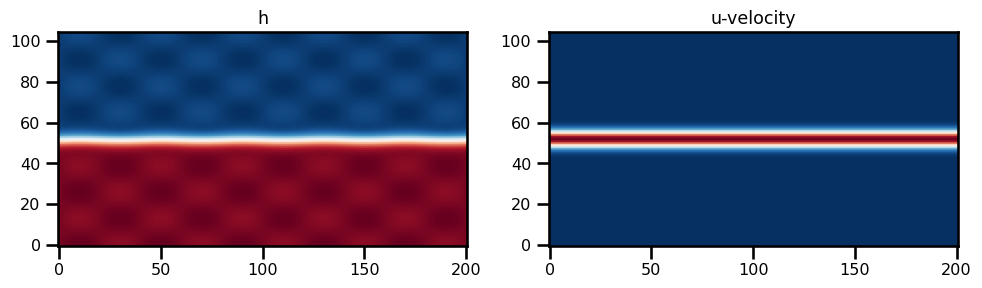

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 12))
ax[0].imshow(h_values.T, origin="lower", cmap="RdBu_r")
ax[0].set(title="h")

ax[1].imshow(u_values.T, origin="lower", cmap="RdBu_r")
ax[1].set(title="u-velocity")

plt.tight_layout()
plt.show()

```python
# initialize h domain
domain = Domain(xmin=(xmin, ymin), xmax=(xmax, ymax), dx=(dx, dy))

# create initialization function
init_h_fn: Callable = ...

# initialize h field
h: Field = Field.init_from_fn(domain, init_fn=init_h_fn)
```

(sec-arakawa-cgrid)=
### Arakawa C-Grid

```{figure} https://veros.readthedocs.io/en/latest/_images/c-grid.svg
:name: fig-arakawa-cgrid
:alt: arakawa C Grid.
:align: center
:width: 400px

Structure of Arakawa C-Grid. The $\zeta$ represents the $h$ in our case. Source: [veros-documentation](https://veros.readthedocs.io/en/latest/introduction/introduction.html)
```

In this example, we will showcase how we can use the Arakawa C-Grid formulation which is very good for fluid flow problems as it can handle fluxes very effectively.


In [59]:
from jaxsw._src.operators.functional import cgrid as C_grid

# stagger domain to the right
# direction - "right", "left"
# stagger - true, false
u_domain = C_grid.stagger_domain(domain, direction=("right", None), stagger=(True, False))
# TODO: catch errors
u_domain

Domain(xmin=(2500.0, 0.0), xmax=(1002500.0, 520000.0), dx=(5000.0, 5000.0))

In [60]:
# C_grid.stagger_domain??#

Some checks for correctness!



In [61]:
def check_h_vs_u_domain(h_domain, u_domain):
    # xcoordinates are perturbed by 1/2 dx
    assert u_domain.xmin[0] == (h_domain.xmin[0] + 0.5 * u_domain.dx[0])
    assert u_domain.xmax[0] == (h_domain.xmax[0] + 0.5 * u_domain.dx[0])
    
    # ycoordinates are the same
    assert u_domain.xmin[1] == h_domain.xmin[1]
    assert u_domain.xmin[1] == h_domain.xmin[1]
    
    # same dimensionality
    assert u_domain.Nx == h_domain.Nx



In [62]:
check_h_vs_u_domain(h_domain=domain, u_domain=u_domain)

We can do the same for the v component

In [63]:
# stagger domain to the right
v_domain = C_grid.stagger_domain(domain, direction=(None, "right"), stagger=(False, True))

In [64]:
def check_h_vs_v_domain(h_domain, v_domain):
    # ycoordinates are perturbed by 1/2 dx
    assert v_domain.xmin[1] == (h_domain.xmin[1] + 0.5 * v_domain.dx[1])
    assert v_domain.xmax[1] == (h_domain.xmax[1] + 0.5 * v_domain.dx[1])
    
    # ycoordinates are the same
    assert v_domain.xmin[0] == h_domain.xmin[0]
    assert v_domain.xmin[0] == h_domain.xmin[0]
    
    # same dimensionality
    assert v_domain.Nx == h_domain.Nx

In [65]:
check_h_vs_v_domain(h_domain=domain, v_domain=v_domain)

Now, we can initialize the u,v components.
We have explicit instructions for the u component.
We can simply initialize the v component with zeros.

In [66]:
# initialize u with custom function
u: Field = Field.init_from_fn(u_domain, init_u0, u_domain, params)

# initialize v with zeros
v: Field = Field(values=jnp.zeros_like(v_domain.grid_axis[0]), domain=v_domain)

# check for correctness
check_h_vs_u_domain(h_domain=domain, u_domain=u_domain)
check_h_vs_v_domain(h_domain=h.domain, v_domain=v.domain)

(105,)


In [69]:
def initialize_state(domain, params):

    h_values: Array = init_h0(domain, params)

    h: Field = Field(values=h_values, domain=domain)

    # stagger domain to the right
    u_domain = C_grid.stagger_domain(domain, direction=("right", None), stagger=(True, False))

    # stagger domain to the right
    v_domain = C_grid.stagger_domain(domain, direction=(None, "right"), stagger=(False, True))

    # initialize u with custom function
    u: Field = Field.init_from_fn(u_domain, init_u0, u_domain, params)
    
    # initialize v with zeros
    v: Field = Field(values=jnp.zeros_like(v_domain.grid_axis[0]), domain=v_domain)

    return h, u, v

In [70]:
u.domain.Nx

(201, 105)

In [71]:
def field_to_xarray(u: Field, names: tp.Iterable[str]=None):

    if names is None:
        names = "xyzabcdefg"
        names = [iname for _, iname in zip(u.domain.Nx,names)]

    # extract coordinates
    coords_dict = {}
    for iname, icoord in zip(names, u.domain.coords_axis):
        coords_dict[iname] = (iname, icoord)

    # create xarray
    return xr.DataArray(
        data=u[:].reshape(u.domain.Nx),
        dims=names,
        coords=coords_dict
    )

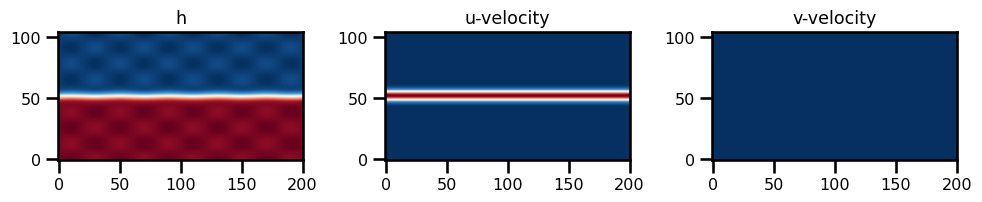

In [72]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(h[:].T, origin="lower", cmap="RdBu_r")
ax[0].set(title="h")

ax[1].imshow(u[:].T, origin="lower", cmap="RdBu_r")
ax[1].set(title="u-velocity")

ax[2].imshow(v[:].T, origin="lower", cmap="RdBu_r")
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

### Boundary Conditions

Here, we create a custom boundary condition function.

In [73]:
def enforce_boundaries(u: Array, component: str = "h", periodic: bool = False):
    if periodic:
        u = u.at[0, :].set(u[-2, :])
        u = u.at[-1, :].set(u[1, :])
    if component == "h":
        return u
    elif component == "u":
        return u.at[-2, :].set(jnp.asarray(0.0))
    elif component == "v":
        return u.at[:, -2].set(jnp.asarray(0.0))
    else:
        msg = f"Unrecognized component: {component}"
        msg += "\nNeeds to be h, u, or v"
        raise ValueError(msg)

Now, we convert it into an operator so that we can use it to operate on the field direction.

In [74]:
from jaxsw._src.operators.custom import FuncOperator

bc_op = FuncOperator(fn=enforce_boundaries)



:::{tip}
:class: dropdown

This is syntactic sugar to remove some of the complexity in dealing with fields. 
Below is a snippet of what's going on under the hood

```python
# define the function and field
fn: Callable = ...
u: Field = ...

# grab the values
u_values: Array = u.values

# apply function to the values
u_values: Array = fn(u_values)

# create a new field with the updated values (and same domain)
u: Field = Field(u_values, domain)

# (Alternatively) we can simply replace the values within the PyTree
u: Field = eqx.tree_map(lambda x: x.values, u, u_values)
```

**Note**: Think of `xarray.apply_ufunc`
:::

In [76]:
# FuncOperator??

In [77]:
h_bc = bc_op(h, component="h")
u_bc = bc_op(u, component="u")
v_bc = bc_op(v, component="v")

In [78]:
def plot_fields(h, u, v, interior: bool=False):
    if not interior:
        interior = slice(None,None)
    else:
        interior = slice(1,-1)
        
    fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
    pts = ax[0].imshow(h[interior].T, origin="lower", cmap="RdBu_r")
    ax[0].set(title="h")
    fig.colorbar(pts, ax=ax[0], shrink=0.9, pad=0.1, orientation="horizontal")
    
    pts2 = ax[1].imshow(u[interior].T, origin="lower", cmap="RdBu_r")
    ax[1].set(title="u-velocity")
    fig.colorbar(pts2, ax=ax[1], shrink=0.9, pad=0.1, orientation="horizontal")
    
    pts3 = ax[2].imshow(v[interior].T, origin="lower", cmap="RdBu_r")
    ax[2].set(title="v-velocity")
    fig.colorbar(pts3, ax=ax[2], shrink=0.9, pad=0.1, orientation="horizontal")
    
    plt.tight_layout()
    plt.show()
    

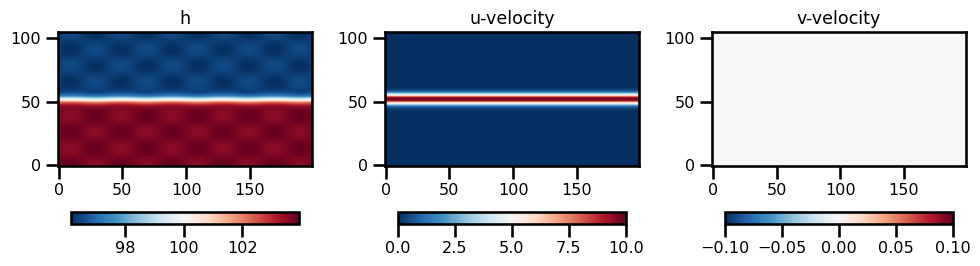

In [79]:
plot_fields(h, u, v, interior=True)

### Constant Values

In [82]:
from jaxsw._src.operators.constant import Constant

In [83]:
c = Constant(jnp.array([0.0]))


In [86]:
# Constant??

In [ ]:
xmin, xmax = ..., ...

In [91]:
# F_interp.field_domain_transform??

## Equation of Motion

### Ghost Points


If we recall from section [Arakawa C-Grid](#sec-arakawa-cgrid) (see [](#fig-arakawa-cgrid)). In this particular formulation, we will add ghost points to each of the domains.

Firstly, we will add ghost points to the $h$ field.
Afterwards, we will reenforce the boundary conditions.

In [ ]:
# pad boundaries with edge values 
# h: [Nx,Ny] --> [Nx+2,Ny+2]
h_pad: Field = C_grid.pad_all_axis(h, mode="constant")

# enforce boundary conditions
h_pad: Field = bc_op(h_pad, "h")


Next, we need to add ghost points to both the velocity fields, $u,v$.
We will use the same API as the above example.
However, this time, we will use the same "edge" values.
Afterwards, we 

In [ ]:
# u-velocity: [Nx, Ny] --> [Nx+2,Ny+2]
u_pad: Field = C_grid.pad_all_axis(u, mode="edge")
# v-velocity: [Nx, Ny] --> [Nx+2,Ny+2]
v_pad: Field = C_grid.pad_all_axis(v, mode="edge")

u_pad: Field =  bc_op(u_pad, "u")
v_pad: Field =  bc_op(v_pad, "v")


In [ ]:


# u-velocity: [Nx+2, Ny+2] --> [Nx+3,Ny+2]
u_pad: Field = C_grid.pad_along_axis(u, pad_width=("left", None), mode="edge")
# v-velocity: [Nx+2, Ny+2] --> [Nx+2,Ny+3]
v_pad: Field = C_grid.pad_along_axis(v, pad_width=(None, "left",), mode="edge")

### H-Equation

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ H
\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0 \\
\end{aligned}
$$ (eq:sw_linear)

In [ ]:
# finite difference
# u --> h 
# [Nx+3,Ny+2] --> [Nx+2,Ny+2]
du_dx: Field = C_grid.difference(u_pad, axis=0, derivative=1)
# [Nx+2, Ny+2] --> [Nx, Ny]
du_dx: Field = F_interp.field_domain_transform(du_dx, h.domain)

# v --> h
# [Nx+2,Ny+3] --> [Nx+2,Ny+2]
dv_dy: Field = C_grid.difference(v_pad, axis=1, derivative=1)
# [Nx+2, Ny+2] --> [Nx, Ny]
dv_dy: Field = F_interp.field_domain_transform(dv_dy, h.domain)

# [Nx, Ny]
h_rhs: Field =  - Constant(params.depth) * (du_dx + dv_dy)

### U-Velocity Equation

$$
\begin{aligned}
\frac{\partial u}{\partial t} &- fv =
- g \frac{\partial h}{\partial x}
- \kappa u 
\end{aligned}
$$ (eq:sw_linear)

In [ ]:
# #############################
# U-VELOCITY
#  ∂u/∂t = fv - g ∂h/∂x
# #############################
# v-velocity: [Nx+2,Ny+3] --> [Nx, Ny]
v_on_u: Field = F_interp.field_domain_transform(v_pad, u.domain)

# PLANETARY VORTICITY (on u)
planetary_vort: Array = params.coriolis_param(u.domain)
planetary_vort: Field = Field(values=planetary_vort, domain=u.domain)

# H --> U
# h: [Nx+2,Ny+2] --> [Nx+1,Ny+2]
dhdx_on_u: Field = C_grid.difference(h_pad, axis=0, derivative=1)
# h: [Nx+1,Ny+2] --> [Nx,Ny]
dhdx_on_u: Field = F_interp.field_domain_transform(dhdx_on_u, u.domain)

# TODO: Check new[:] == old[1:,1:-1]

u_rhs: Field = planetary_vort * v_on_u - Constant(params.gravity) * dhdx_on_u


### V-Velocity Equation

$$
\begin{aligned}
\frac{\partial v}{\partial t} &+ fu =
- g \frac{\partial h}{\partial y}
- \kappa v
\end{aligned}
$$ (eq:sw_linear)

In [ ]:
# #############################
# V - VELOCITY
# ∂v/∂t = - fu - g ∂h/∂y
# #############################
# u-velocity: [Nx+3,Ny+2] --> [Nx, Ny]
u_on_v: Field = F_interp.field_domain_transform(u_pad, v.domain)

# PLANETARY VORTICITY (on v)
planetary_vort: Array = params.coriolis_param(v.domain)
planetary_vort: Field = Field(values=planetary_vort, domain=v.domain)

# H --> V
# h: [Nx+2,Ny+2] --> [Nx+2,Ny+1]
dhdx_on_v: Field = C_grid.difference(h_pad, axis=1, derivative=1)
# h: [Nx+1,Ny+2] --> [Nx,Ny]
dhdx_on_v: Field = F_interp.field_domain_transform(dhdx_on_v, v.domain)
# V-Velocity RHS: [Nx, Ny]
v_rhs: Field = - planetary_vort * u_on_v - Constant(params.gravity) * dhdx_on_v


### Final Combined Equations

In [125]:
import jaxsw._src.operators.functional.interp as F_interp

def equation_of_motion(t: float, state: tp.Tuple[Field], args: Params) -> tp.Tuple[Field]:
    params = args
    # parse state
    h, u, v = state

    # enforce boundary conditions
    h = bc_op(h, "h")
    v = bc_op(v, "v")
    u = bc_op(u, "u")

    # ###############################################
    #                PADDED ARAKAWA C-GRID
    # ###############################################
    #
    #
    #                   V ----------- V
    #                   |             |
    #                   |             |
    #            U ---- Ψ ---- U ---- Ψ ---- U
    #            |      |             |      |
    #            |      V      Q      V      |
    #            |      |             |      |
    #            U ---- Ψ ---- U ---- Ψ ---- U
    #                   |             |
    #                   |             |
    #                   V ----------- V
    # 
    # 
    # SIZES
    # 
    # Ψ: [Nx,Ny]          H_ghost:  [Nx+2,Ny+2]
    # U: [Nx,Ny]          U_ghost:  [Nx+3,Ny+2]
    # V: [Nx,Ny]          V_ghost:  [Nx+2,Ny+3]
    # ###############################################
    
    # pad boundaries with edge values 
    # h: [Nx,Ny] --> [Nx+2,Ny+2]
    h_pad: Field = C_grid.pad_all_axis(h, mode="constant")
    
    # enforce boundary conditions
    h_pad: Field = bc_op(h_pad, "h")
    
    # u-velocity: [Nx, Ny] --> [Nx+2,Ny+2]
    u_pad: Field = C_grid.pad_all_axis(u, mode="edge")
    # v-velocity: [Nx, Ny] --> [Nx+2,Ny+2]
    v_pad: Field = C_grid.pad_all_axis(v, mode="edge")
    
    u_pad: Field =  bc_op(u_pad, "u")
    v_pad: Field =  bc_op(v_pad, "v")
    
    # u-velocity: [Nx+2, Ny+2] --> [Nx+3,Ny+2]
    u_pad: Field = C_grid.pad_along_axis(u, pad_width=("left", None), mode="edge")
    # v-velocity: [Nx+2, Ny+2] --> [Nx+2,Ny+3]
    v_pad: Field = C_grid.pad_along_axis(v, pad_width=(None, "left",), mode="edge")


    # ################################
    # HEIGHT Equation
    # ∂h/∂t = - H (∂u/∂x + ∂v/∂y)
    # ################################

    # finite difference
    # u --> h 
    # [Nx+3,Ny+2] --> [Nx+2,Ny+2]
    du_dx: Field = C_grid.difference(u_pad, axis=0, derivative=1)
    # [Nx+2, Ny+2] --> [Nx, Ny]
    du_dx: Field = F_interp.field_domain_transform(du_dx, h.domain)

    # v --> h
    # [Nx+2,Ny+3] --> [Nx+2,Ny+2]
    dv_dy: Field = C_grid.difference(v_pad, axis=1, derivative=1)
    # [Nx+2, Ny+2] --> [Nx, Ny]
    dv_dy: Field = F_interp.field_domain_transform(dv_dy, h.domain)

    # [Nx, Ny]
    h_rhs: Field =  - Constant(params.depth) * (du_dx + dv_dy)


    # #############################
    # U-VELOCITY
    #  ∂u/∂t = fv - g ∂h/∂x
    # #############################
    # v-velocity: [Nx+2,Ny+3] --> [Nx, Ny]
    v_on_u: Field = F_interp.field_domain_transform(v_pad, u.domain)
    
    # PLANETARY VORTICITY (on u)
    planetary_vort: Array = params.coriolis_param(u.domain)
    planetary_vort: Field = Field(values=planetary_vort, domain=u.domain)
    
    # H --> U
    # h: [Nx+2,Ny+2] --> [Nx+1,Ny+2]
    dhdx_on_u: Field = C_grid.difference(h_pad, axis=0, derivative=1)
    # h: [Nx+1,Ny+2] --> [Nx,Ny]
    dhdx_on_u: Field = F_interp.field_domain_transform(dhdx_on_u, u.domain)
    
    u_rhs: Field = planetary_vort * v_on_u - Constant(params.gravity) * dhdx_on_u
    
    
    # #############################
    # V - VELOCITY
    # ∂v/∂t = - fu - g ∂h/∂y
    # #############################
    # u-velocity: [Nx+3,Ny+2] --> [Nx, Ny]
    u_on_v: Field = F_interp.field_domain_transform(u_pad, v.domain)
    
    # PLANETARY VORTICITY (on v)
    planetary_vort: Array = params.coriolis_param(v.domain)
    planetary_vort: Field = Field(values=planetary_vort, domain=v.domain)
    
    # H --> V
    # h: [Nx+2,Ny+2] --> [Nx+2,Ny+1]
    dhdx_on_v: Field = C_grid.difference(h_pad, axis=1, derivative=1)
    # h: [Nx+1,Ny+2] --> [Nx,Ny]
    dhdx_on_v: Field = F_interp.field_domain_transform(dhdx_on_v, v.domain)
    # V-Velocity RHS: [Nx, Ny]
    v_rhs: Field = - planetary_vort * u_on_v - Constant(params.gravity) * dhdx_on_v


    return (h_rhs, u_rhs, v_rhs)

In [126]:
h_rhs, u_rhs, v_rhs = equation_of_motion(0, (h,u,v), params)
h_rhs, u_rhs, v_rhs

(Field(
   values=f64[201,105],
   domain=Domain(
     xmin=(0.0, 0.0),
     xmax=(1000000.0, 520000.0),
     dx=(5000.0, 5000.0)
   )
 ),
 Field(
   values=f64[201,105],
   domain=Domain(
     xmin=(2500.0, 0.0),
     xmax=(1002500.0, 520000.0),
     dx=(5000.0, 5000.0)
   )
 ),
 Field(
   values=f64[201,105],
   domain=Domain(
     xmin=(0.0, 2500.0),
     xmax=(1000000.0, 522500.0),
     dx=(5000.0, 5000.0)
   )
 ))

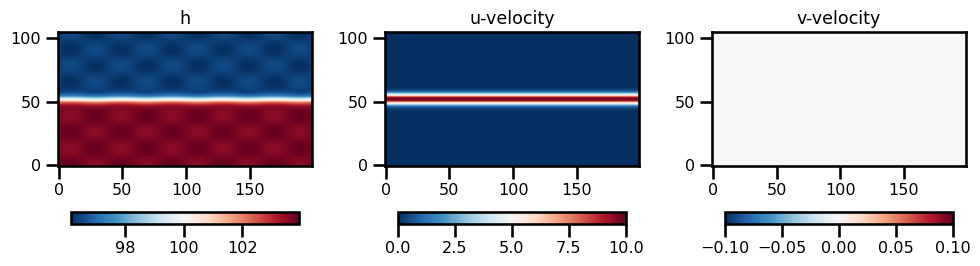

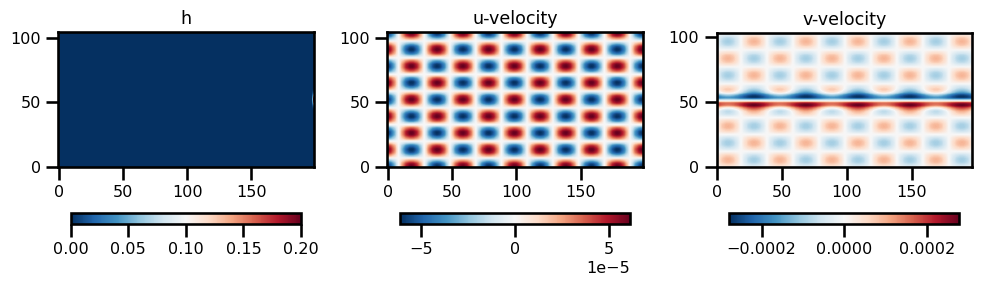

In [127]:
plot_fields(h, u, v, interior=True)
plot_fields(h_rhs, u_rhs, v_rhs[1:-1,1:-1], interior=True)

## Time Stepping

In [128]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain

dt = 0.125 * domain.dx[0] / np.sqrt(params.gravity * params.depth)
print(f"Step Size (dt): {dt:.4e}")

tmin = 0.0
tmax = pd.to_timedelta(2.0, unit="days").total_seconds()
num_save = 20

Step Size (dt): 1.9955e+01


In [129]:
import pandas as pd

In [130]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)


In [131]:
def initialize_state(domain, params):

    h_values: Array = init_h0(domain, params)

    h: Field = Field(values=h_values, domain=domain)

    # stagger domain to the right
    u_domain = C_grid.stagger_domain(domain, direction=("right", None), stagger=(True, False))

    # stagger domain to the right
    v_domain = C_grid.stagger_domain(domain, direction=(None, "right"), stagger=(False, True))

    # initialize u with custom function
    u: Field = Field.init_from_fn(u_domain, init_u0, u_domain, params)
    
    # initialize v with zeros
    v: Field = Field(values=jnp.zeros_like(v_domain.grid_axis[0]), domain=v_domain)

    return (h, u, v)

In [132]:
state_init = initialize_state(domain, params)

(105,)
(105,)


In [133]:
# Euler, Constant StepSize
solver = dfx.Dopri5()

# Tolerances
stepsize_controller = dfx.ConstantStepSize()


# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(equation_of_motion),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

In [134]:
def field_solution_to_xarray(u, ts, names: tp.Iterable[str]=None):


    if names is None:
        names = "xyzabcdefg"
        names = [iname for _, iname in zip(u.domain.Nx,names)]

    # extract coordinates
    coords_dict = {}
    for iname, icoord in zip(names, u.domain.coords_axis):
        coords_dict[iname] = (iname, icoord)

    coords_dict["time"] = ("time", ts)
    # create xarray
    return xr.DataArray(
        data=u[:].reshape((len(ts),) + u.domain.Nx),
        dims=["time"] + names,
        coords=coords_dict
    )

In [135]:
h_sol = jax.vmap(F_interp.field_domain_transform)(sol.ys[0], h.domain)
u_sol = jax.vmap(F_interp.field_domain_transform)(sol.ys[1], h.domain)
v_sol = jax.vmap(F_interp.field_domain_transform)(sol.ys[2], h.domain)
# np.testing.assert_array_almost_equal(h_sol[1:-1,1:-1], sol.ys[0][1:-1,1:-1])

In [136]:

xrds = [field_solution_to_xarray(ivar, sol.ts) for ivar in [h_sol, u_sol, v_sol]]

xrds = [ivar.rename(iname) for iname, ivar in zip(*(["h","u","v"],xrds))]

xrds = xr.merge(xrds,)

In [137]:
xrds

<xarray.Dataset>
Dimensions:  (x: 201, y: 105, time: 20)
Coordinates:
  * x        (x) float64 0.0 5e+03 1e+04 1.5e+04 ... 9.9e+05 9.95e+05 1e+06
  * y        (y) float64 0.0 5e+03 1e+04 1.5e+04 ... 5.1e+05 5.15e+05 5.2e+05
  * time     (time) float64 0.0 9.095e+03 1.819e+04 ... 1.637e+05 1.728e+05
Data variables:
    h        (time, x, y) float64 103.7 103.7 103.7 ... -86.78 -89.41 -54.43
    u        (time, x, y) float64 4.02e-73 2.512e-70 ... 1.731e+04 21.79
    v        (time, x, y) float64 0.0 0.0 0.0 0.0 ... 0.5847 0.4204 20.7 11.56

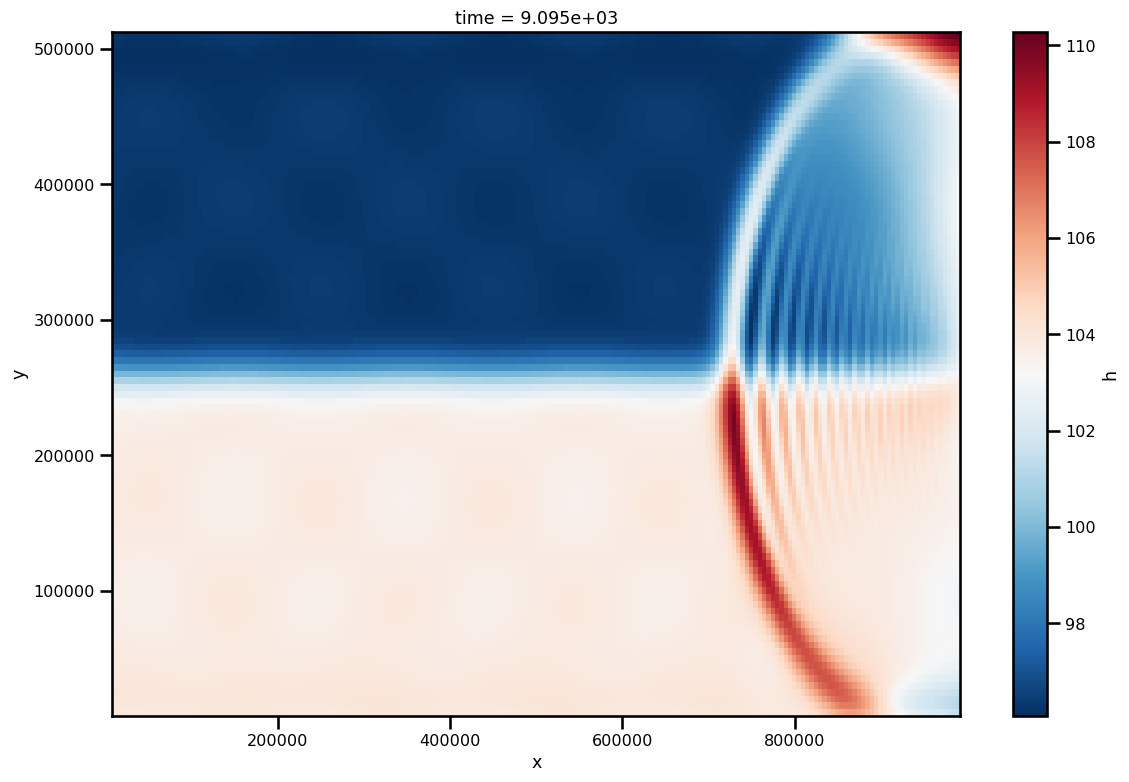

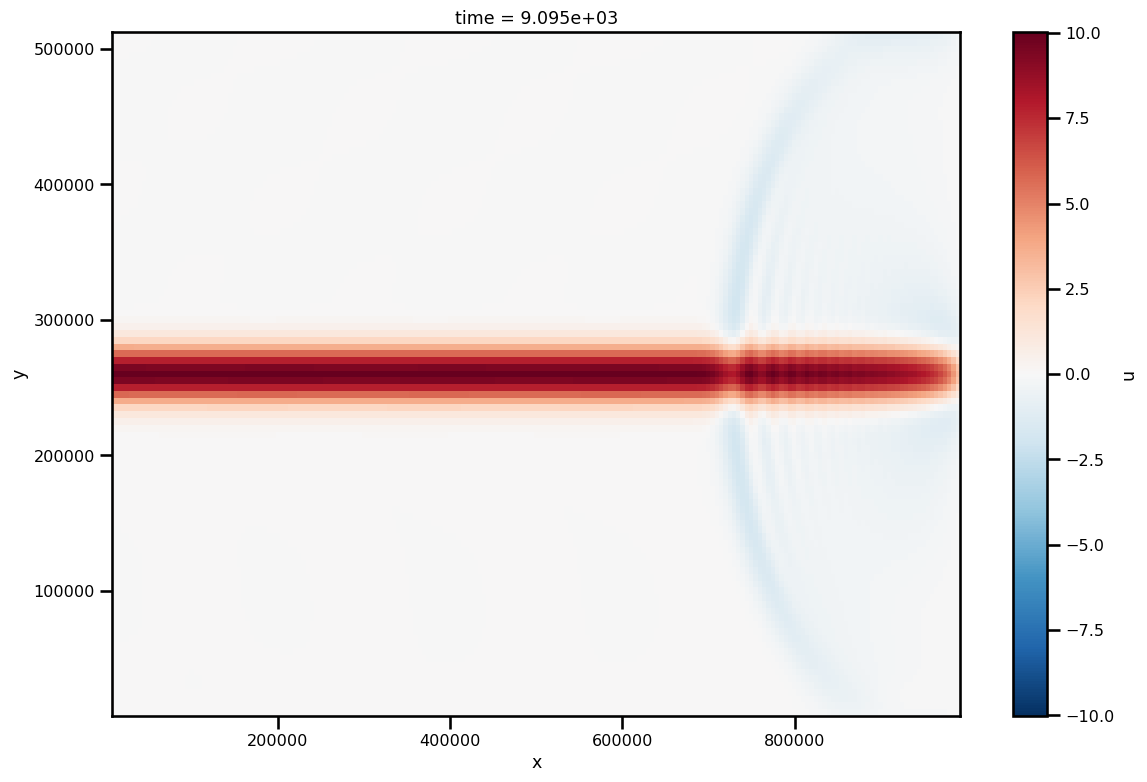

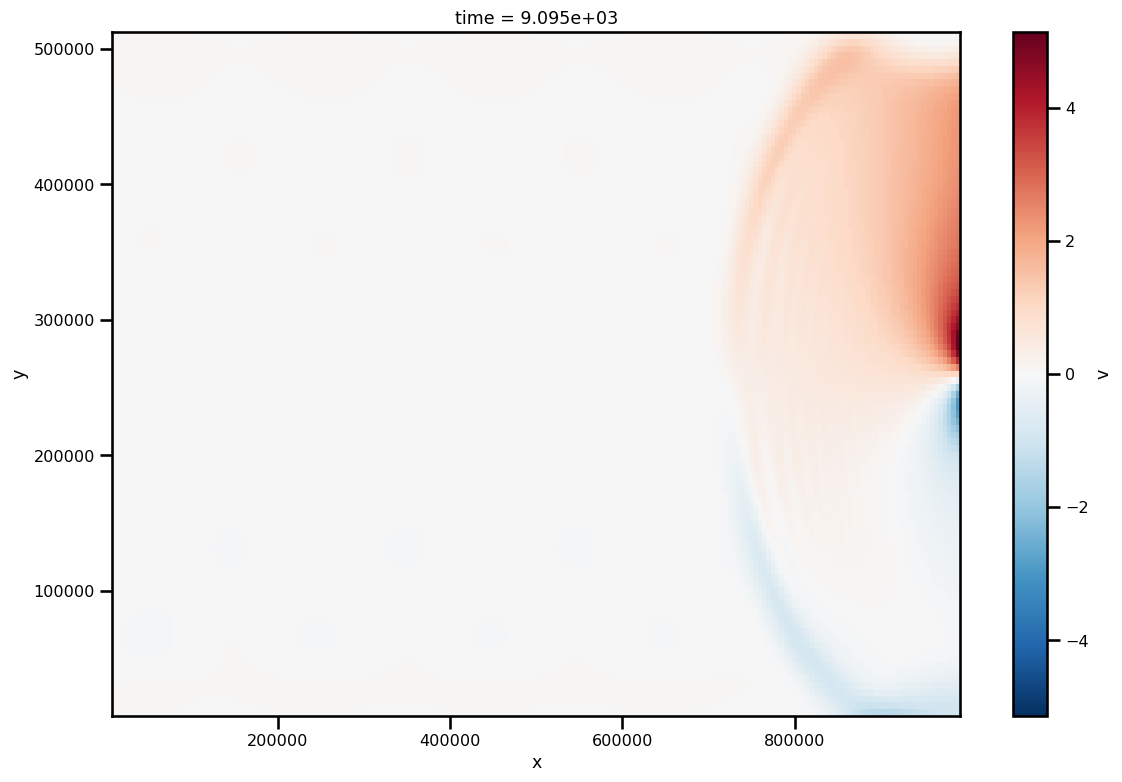

In [138]:
for ivar in ["h", "u", "v"]:
    fig, ax = plt.subplots(figsize=(12,8))
    xrds[ivar].isel(time=1, x=slice(2,-2), y=slice(2,-2)).T.plot.imshow(ax=ax, origin="lower", cmap="RdBu_r")
    plt.tight_layout()
    plt.show()